# AST‐Powered Autoencoder for DCASE‑Inspired Anomalous Sound Detection


In [1]:
# Install dependencies (uncomment if needed)
!pip install timm==0.4.5

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os, glob, random, json
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import librosa, librosa.display
import numpy as np

In [3]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)


Using device: cuda


## AST Feature Extraction Demo Integration

In [4]:
from asts.src.models import ASTModel

# Define visualization subclass
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        nh = block.attn.num_heads
        scale = block.attn.scale
        B,N,C = x.shape
        qkv = qkv(x).reshape(B,N,3,nh,C//nh).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * scale
        return attn.softmax(dim=-1)
    def forward_visualization(self, x):
        x = x.unsqueeze(1).transpose(2,3)
        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls = self.v.cls_token.expand(B,-1,-1)
        dist= self.v.dist_token.expand(B,-1,-1)
        x = torch.cat((cls,dist,x),dim=1)+self.v.pos_embed
        attn_maps=[]
        for blk in self.v.blocks:
            att = self.get_att_map(blk,x)
            attn_maps.append(att)
            x = blk(x)
        return attn_maps

# Download pretrained AST weights
os.makedirs('ast_models', exist_ok=True)
ckpt=r'C:\Users\dell\Desktop\Projects\aml-main\aml-main\Challenge_2\asts\pretrained_models\audioset_10_10_0.4593.pth'

# Initialize AST model
model_ast = ASTModelVis(label_dim=527,input_tdim=1024,imagenet_pretrain=False,audioset_pretrain=False)
state = torch.load(ckpt,map_location=DEVICE)
model_ast = torch.nn.DataParallel(model_ast).to(DEVICE)
model_ast.load_state_dict(state)
model_ast.eval()


c:\Users\dell\Desktop\Projects\aml-main\aml-main\Challenge_2\asts\src\models\ast_models.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212


DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

## Data Preparation & AST CLS Embedding Extraction

In [5]:
TRAIN_DIR='DATA/dev_data/dev_data/slider/train'
TEST_DIR ='DATA/dev_data/dev_data/slider/test'
EMB_DIR ='DATA/embeddings_ast'
os.makedirs(f'{EMB_DIR}/train',exist_ok=True)
os.makedirs(f'{EMB_DIR}/test', exist_ok=True)

import torchaudio.functional as Ffunc
def make_feats(path):
    wav, sr = torchaudio.load(path)
    assert sr==16000,'Sampling rate must be 16kHz'
    fbank = torchaudio.compliance.kaldi.fbank(
        wav, htk_compat=True, sample_frequency=sr,
        use_energy=False, window_type='hanning',
        num_mel_bins=128, dither=0.0, frame_shift=10)
    # normalize with precomputed mean/std
    return (fbank - (-4.2677))/(4.5689*2)

for split,files in [('train',sorted(glob.glob(f'{TRAIN_DIR}/*.wav'))),
                    ('test', sorted(glob.glob(f'{TEST_DIR}/*.wav')))]:
    out_dir=os.path.join(EMB_DIR,split)
    for wav in tqdm(files,desc=f'AST Emb {split}',leave=False):
        name=os.path.basename(wav).replace('.wav','.npy')
        p=os.path.join(out_dir,name)
        if os.path.exists(p): continue
        feats=make_feats(wav)[None,:,:]
        with torch.no_grad():
            # forward_visualization to get attn, but we take cls token embedding
            # easier: use standard forward, get output before classifier
            x = feats.unsqueeze(1).transpose(2,3).to(DEVICE)
            B= x.shape[0]
            x = model_ast.module.v.patch_embed(x)
            cls = model_ast.module.v.cls_token.expand(B,-1,-1)
            x = torch.cat((cls, x), dim=1)
            if x.shape[1] != model_ast.module.v.pos_embed.shape[1]:
                pe = model_ast.module.v.pos_embed
                cls_token = pe[:, :1, :]
                pos_tokens = pe[:, 1:, :]

                # interpolate position tokens to match input length - 1
                new_len = x.shape[1] - 1
                pos_tokens_interp = torch.nn.functional.interpolate(
                    pos_tokens.permute(0, 2, 1), size=new_len, mode='linear', align_corners=False
                ).permute(0, 2, 1)

                x = x + torch.cat([cls_token, pos_tokens_interp], dim=1)
            else:
                x = x + model_ast.module.v.pos_embed

            # run through blocks
            for blk in model_ast.module.v.blocks:
                x = blk(x)
        emb = x[:,0].cpu().numpy()  # CLS embedding
        np.save(p, emb)


## Dataset, Autoencoder & Training on AST Embeddings

In [6]:
class ASTDataset(Dataset):
    def __init__(self, folder): self.files=sorted(glob.glob(folder+'/*.npy'))
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        arr=np.load(self.files[idx]); x=torch.tensor(arr).float()
        y=0 if 'normal' in self.files[idx] else 1
        return x,y

train_ds=ASTDataset(f'{EMB_DIR}/train')
test_ds =ASTDataset(f'{EMB_DIR}/test')
train_dl=DataLoader(train_ds,batch_size=512,shuffle=True)
test_dl =DataLoader(test_ds ,batch_size=512)

# Simple FC AE for AST embeddings
DIM=768
class EmbAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc=nn.Linear(DIM,256)
        self.dec=nn.Linear(256,DIM)
    def forward(self,x): return self.dec(torch.relu(self.enc(x)))
model=EmbAE().to(DEVICE)



In [7]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500

# Scheduler + ear|ly-stop params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=10, 
)
patience = 20       # how many epochs to wait for loss improvement
min_delta = 1e-4    # minimum change in loss to count as “improved”

history = []
best_loss = float('inf')
stale_epochs = 0

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}', leave=False):
        x = x.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)

    avg = total_loss / len(train_ds)
    history.append(avg)
    print(f'Epoch {ep:2d} loss={avg:.6f}')

    # step the LR scheduler on the validation metric (here train loss)
    scheduler.step(avg)

    # early-stopping check
    if best_loss - avg > min_delta:
        best_loss = avg
        stale_epochs = 0
        print(f"  ↳ Improvement detected (new best_loss={best_loss:.6f}). Patience reset.")
    else:
        stale_epochs += 1
        print(f"  ↳ No significant improvement for {stale_epochs}/{patience} epochs.")
        if stale_epochs >= patience:
            print(f"Early stopping at epoch {ep}: no loss decrease >{min_delta} for {patience} epochs.")
            break


Epoch  1 loss=0.448145
  ↳ Improvement detected (new best_loss=0.448145). Patience reset.


Epoch  2 loss=0.254683
  ↳ Improvement detected (new best_loss=0.254683). Patience reset.


Epoch  3 loss=0.194858
  ↳ Improvement detected (new best_loss=0.194858). Patience reset.


Epoch  4 loss=0.164242
  ↳ Improvement detected (new best_loss=0.164242). Patience reset.


Epoch  5 loss=0.135770
  ↳ Improvement detected (new best_loss=0.135770). Patience reset.


Epoch  6 loss=0.117234
  ↳ Improvement detected (new best_loss=0.117234). Patience reset.


Epoch  7 loss=0.104635
  ↳ Improvement detected (new best_loss=0.104635). Patience reset.


Epoch  8 loss=0.094930
  ↳ Improvement detected (new best_loss=0.094930). Patience reset.


Epoch  9 loss=0.087970
  ↳ Improvement detected (new best_loss=0.087970). Patience reset.


Epoch 10 loss=0.082482
  ↳ Improvement detected (new best_loss=0.082482). Patience reset.


Epoch 11 loss=0.078004
  ↳ Improvement detected (new best_loss=0.078004). Patience reset.


Epoch 12 loss=0.074093
  ↳ Improvement detected (new best_loss=0.074093). Patience reset.


Epoch 13 loss=0.070680
  ↳ Improvement detected (new best_loss=0.070680). Patience reset.


Epoch 14 loss=0.067622
  ↳ Improvement detected (new best_loss=0.067622). Patience reset.


Epoch 15 loss=0.064931
  ↳ Improvement detected (new best_loss=0.064931). Patience reset.


Epoch 16 loss=0.062509
  ↳ Improvement detected (new best_loss=0.062509). Patience reset.


Epoch 17 loss=0.060375
  ↳ Improvement detected (new best_loss=0.060375). Patience reset.


Epoch 18 loss=0.058412
  ↳ Improvement detected (new best_loss=0.058412). Patience reset.


Epoch 19 loss=0.056624
  ↳ Improvement detected (new best_loss=0.056624). Patience reset.


Epoch 20 loss=0.054973
  ↳ Improvement detected (new best_loss=0.054973). Patience reset.


Epoch 21 loss=0.053474
  ↳ Improvement detected (new best_loss=0.053474). Patience reset.


Epoch 22 loss=0.052067
  ↳ Improvement detected (new best_loss=0.052067). Patience reset.


Epoch 23 loss=0.050708
  ↳ Improvement detected (new best_loss=0.050708). Patience reset.


Epoch 24 loss=0.049470
  ↳ Improvement detected (new best_loss=0.049470). Patience reset.


Epoch 25 loss=0.048299
  ↳ Improvement detected (new best_loss=0.048299). Patience reset.


Epoch 26 loss=0.047190
  ↳ Improvement detected (new best_loss=0.047190). Patience reset.


Epoch 27 loss=0.046135
  ↳ Improvement detected (new best_loss=0.046135). Patience reset.


Epoch 28 loss=0.045138
  ↳ Improvement detected (new best_loss=0.045138). Patience reset.


Epoch 29 loss=0.044219
  ↳ Improvement detected (new best_loss=0.044219). Patience reset.


Epoch 30 loss=0.043335
  ↳ Improvement detected (new best_loss=0.043335). Patience reset.


Epoch 31 loss=0.042520
  ↳ Improvement detected (new best_loss=0.042520). Patience reset.


Epoch 32 loss=0.041726
  ↳ Improvement detected (new best_loss=0.041726). Patience reset.


Epoch 33 loss=0.041000
  ↳ Improvement detected (new best_loss=0.041000). Patience reset.


Epoch 34 loss=0.040289
  ↳ Improvement detected (new best_loss=0.040289). Patience reset.


Epoch 35 loss=0.039621
  ↳ Improvement detected (new best_loss=0.039621). Patience reset.


Epoch 36 loss=0.038975
  ↳ Improvement detected (new best_loss=0.038975). Patience reset.


Epoch 37 loss=0.038384
  ↳ Improvement detected (new best_loss=0.038384). Patience reset.


Epoch 38 loss=0.037793
  ↳ Improvement detected (new best_loss=0.037793). Patience reset.


Epoch 39 loss=0.037236
  ↳ Improvement detected (new best_loss=0.037236). Patience reset.


Epoch 40 loss=0.036707
  ↳ Improvement detected (new best_loss=0.036707). Patience reset.


Epoch 41 loss=0.036179
  ↳ Improvement detected (new best_loss=0.036179). Patience reset.


Epoch 42 loss=0.035666
  ↳ Improvement detected (new best_loss=0.035666). Patience reset.


Epoch 43 loss=0.035167
  ↳ Improvement detected (new best_loss=0.035167). Patience reset.


Epoch 44 loss=0.034712
  ↳ Improvement detected (new best_loss=0.034712). Patience reset.


Epoch 45 loss=0.034260
  ↳ Improvement detected (new best_loss=0.034260). Patience reset.


Epoch 46 loss=0.033837
  ↳ Improvement detected (new best_loss=0.033837). Patience reset.


Epoch 47 loss=0.033433
  ↳ Improvement detected (new best_loss=0.033433). Patience reset.


Epoch 48 loss=0.033033
  ↳ Improvement detected (new best_loss=0.033033). Patience reset.


Epoch 49 loss=0.032651
  ↳ Improvement detected (new best_loss=0.032651). Patience reset.


Epoch 50 loss=0.032294
  ↳ Improvement detected (new best_loss=0.032294). Patience reset.


Epoch 51 loss=0.031929
  ↳ Improvement detected (new best_loss=0.031929). Patience reset.


Epoch 52 loss=0.031583
  ↳ Improvement detected (new best_loss=0.031583). Patience reset.


Epoch 53 loss=0.031247
  ↳ Improvement detected (new best_loss=0.031247). Patience reset.


Epoch 54 loss=0.030926
  ↳ Improvement detected (new best_loss=0.030926). Patience reset.


Epoch 55 loss=0.030619
  ↳ Improvement detected (new best_loss=0.030619). Patience reset.


Epoch 56 loss=0.030320
  ↳ Improvement detected (new best_loss=0.030320). Patience reset.


Epoch 57 loss=0.030002
  ↳ Improvement detected (new best_loss=0.030002). Patience reset.


Epoch 58 loss=0.029686
  ↳ Improvement detected (new best_loss=0.029686). Patience reset.


Epoch 59 loss=0.029425
  ↳ Improvement detected (new best_loss=0.029425). Patience reset.


Epoch 60 loss=0.029153
  ↳ Improvement detected (new best_loss=0.029153). Patience reset.


Epoch 61 loss=0.028903
  ↳ Improvement detected (new best_loss=0.028903). Patience reset.


Epoch 62 loss=0.028640
  ↳ Improvement detected (new best_loss=0.028640). Patience reset.


Epoch 63 loss=0.028411
  ↳ Improvement detected (new best_loss=0.028411). Patience reset.


Epoch 64 loss=0.028158
  ↳ Improvement detected (new best_loss=0.028158). Patience reset.


Epoch 65 loss=0.027922
  ↳ Improvement detected (new best_loss=0.027922). Patience reset.


Epoch 66 loss=0.027695
  ↳ Improvement detected (new best_loss=0.027695). Patience reset.


Epoch 67 loss=0.027489
  ↳ Improvement detected (new best_loss=0.027489). Patience reset.


Epoch 68 loss=0.027231
  ↳ Improvement detected (new best_loss=0.027231). Patience reset.


Epoch 69 loss=0.027018
  ↳ Improvement detected (new best_loss=0.027018). Patience reset.


Epoch 70 loss=0.026784
  ↳ Improvement detected (new best_loss=0.026784). Patience reset.


Epoch 71 loss=0.026600
  ↳ Improvement detected (new best_loss=0.026600). Patience reset.


Epoch 72 loss=0.026454
  ↳ Improvement detected (new best_loss=0.026454). Patience reset.


Epoch 73 loss=0.026229
  ↳ Improvement detected (new best_loss=0.026229). Patience reset.


Epoch 74 loss=0.026078
  ↳ Improvement detected (new best_loss=0.026078). Patience reset.


Epoch 75 loss=0.025866
  ↳ Improvement detected (new best_loss=0.025866). Patience reset.


Epoch 76 loss=0.025660
  ↳ Improvement detected (new best_loss=0.025660). Patience reset.


Epoch 77 loss=0.025511
  ↳ Improvement detected (new best_loss=0.025511). Patience reset.


Epoch 78 loss=0.025328
  ↳ Improvement detected (new best_loss=0.025328). Patience reset.


Epoch 79 loss=0.025121
  ↳ Improvement detected (new best_loss=0.025121). Patience reset.


Epoch 80 loss=0.024970
  ↳ Improvement detected (new best_loss=0.024970). Patience reset.


Epoch 81 loss=0.024806
  ↳ Improvement detected (new best_loss=0.024806). Patience reset.


Epoch 82 loss=0.024636
  ↳ Improvement detected (new best_loss=0.024636). Patience reset.


Epoch 83 loss=0.024490
  ↳ Improvement detected (new best_loss=0.024490). Patience reset.


Epoch 84 loss=0.024318
  ↳ Improvement detected (new best_loss=0.024318). Patience reset.


Epoch 85 loss=0.024152
  ↳ Improvement detected (new best_loss=0.024152). Patience reset.


Epoch 86 loss=0.023998
  ↳ Improvement detected (new best_loss=0.023998). Patience reset.


Epoch 87 loss=0.023874
  ↳ Improvement detected (new best_loss=0.023874). Patience reset.


Epoch 88 loss=0.023903
  ↳ No significant improvement for 1/20 epochs.


Epoch 89 loss=0.023785
  ↳ No significant improvement for 2/20 epochs.


Epoch 90 loss=0.023551
  ↳ Improvement detected (new best_loss=0.023551). Patience reset.


Epoch 91 loss=0.023338
  ↳ Improvement detected (new best_loss=0.023338). Patience reset.


Epoch 92 loss=0.023195
  ↳ Improvement detected (new best_loss=0.023195). Patience reset.


Epoch 93 loss=0.023037
  ↳ Improvement detected (new best_loss=0.023037). Patience reset.


Epoch 94 loss=0.022916
  ↳ Improvement detected (new best_loss=0.022916). Patience reset.


Epoch 95 loss=0.022787
  ↳ Improvement detected (new best_loss=0.022787). Patience reset.


Epoch 96 loss=0.022671
  ↳ Improvement detected (new best_loss=0.022671). Patience reset.


Epoch 97 loss=0.022562
  ↳ Improvement detected (new best_loss=0.022562). Patience reset.


Epoch 98 loss=0.022468
  ↳ No significant improvement for 1/20 epochs.


Epoch 99 loss=0.022333
  ↳ Improvement detected (new best_loss=0.022333). Patience reset.


Epoch 100 loss=0.022189
  ↳ Improvement detected (new best_loss=0.022189). Patience reset.


Epoch 101 loss=0.022090
  ↳ No significant improvement for 1/20 epochs.


Epoch 102 loss=0.021980
  ↳ Improvement detected (new best_loss=0.021980). Patience reset.


Epoch 103 loss=0.021934
  ↳ No significant improvement for 1/20 epochs.


Epoch 104 loss=0.022062
  ↳ No significant improvement for 2/20 epochs.


Epoch 105 loss=0.021731
  ↳ Improvement detected (new best_loss=0.021731). Patience reset.


Epoch 106 loss=0.021620
  ↳ Improvement detected (new best_loss=0.021620). Patience reset.


Epoch 107 loss=0.021529
  ↳ No significant improvement for 1/20 epochs.


Epoch 108 loss=0.021378
  ↳ Improvement detected (new best_loss=0.021378). Patience reset.


Epoch 109 loss=0.021271
  ↳ Improvement detected (new best_loss=0.021271). Patience reset.


Epoch 110 loss=0.021173
  ↳ No significant improvement for 1/20 epochs.


Epoch 111 loss=0.021047
  ↳ Improvement detected (new best_loss=0.021047). Patience reset.


Epoch 112 loss=0.020965
  ↳ No significant improvement for 1/20 epochs.


Epoch 113 loss=0.020953
  ↳ No significant improvement for 2/20 epochs.


Epoch 114 loss=0.020921
  ↳ Improvement detected (new best_loss=0.020921). Patience reset.


Epoch 115 loss=0.020752
  ↳ Improvement detected (new best_loss=0.020752). Patience reset.


Epoch 116 loss=0.020619
  ↳ Improvement detected (new best_loss=0.020619). Patience reset.


Epoch 117 loss=0.020505
  ↳ Improvement detected (new best_loss=0.020505). Patience reset.


Epoch 118 loss=0.020463
  ↳ No significant improvement for 1/20 epochs.


Epoch 119 loss=0.020375
  ↳ Improvement detected (new best_loss=0.020375). Patience reset.


Epoch 120 loss=0.020315
  ↳ No significant improvement for 1/20 epochs.


Epoch 121 loss=0.020284
  ↳ No significant improvement for 2/20 epochs.


Epoch 122 loss=0.020164
  ↳ Improvement detected (new best_loss=0.020164). Patience reset.


Epoch 123 loss=0.020035
  ↳ Improvement detected (new best_loss=0.020035). Patience reset.


Epoch 124 loss=0.019932
  ↳ Improvement detected (new best_loss=0.019932). Patience reset.


Epoch 125 loss=0.019875
  ↳ No significant improvement for 1/20 epochs.


Epoch 126 loss=0.019837
  ↳ No significant improvement for 2/20 epochs.


Epoch 127 loss=0.019746
  ↳ Improvement detected (new best_loss=0.019746). Patience reset.


Epoch 128 loss=0.019819
  ↳ No significant improvement for 1/20 epochs.


Epoch 129 loss=0.019816
  ↳ No significant improvement for 2/20 epochs.


Epoch 130 loss=0.019623
  ↳ Improvement detected (new best_loss=0.019623). Patience reset.


Epoch 131 loss=0.019551
  ↳ No significant improvement for 1/20 epochs.


Epoch 132 loss=0.019406
  ↳ Improvement detected (new best_loss=0.019406). Patience reset.


Epoch 133 loss=0.019328
  ↳ No significant improvement for 1/20 epochs.


Epoch 134 loss=0.019268
  ↳ Improvement detected (new best_loss=0.019268). Patience reset.


Epoch 135 loss=0.019220
  ↳ No significant improvement for 1/20 epochs.


Epoch 136 loss=0.019130
  ↳ Improvement detected (new best_loss=0.019130). Patience reset.


Epoch 137 loss=0.019051
  ↳ No significant improvement for 1/20 epochs.


Epoch 138 loss=0.018989
  ↳ Improvement detected (new best_loss=0.018989). Patience reset.


Epoch 139 loss=0.019016
  ↳ No significant improvement for 1/20 epochs.


Epoch 140 loss=0.019160
  ↳ No significant improvement for 2/20 epochs.


Epoch 141 loss=0.018876
  ↳ Improvement detected (new best_loss=0.018876). Patience reset.


Epoch 142 loss=0.018854
  ↳ No significant improvement for 1/20 epochs.


Epoch 143 loss=0.018815
  ↳ No significant improvement for 2/20 epochs.


Epoch 144 loss=0.018645
  ↳ Improvement detected (new best_loss=0.018645). Patience reset.


Epoch 145 loss=0.018588
  ↳ No significant improvement for 1/20 epochs.


Epoch 146 loss=0.018498
  ↳ Improvement detected (new best_loss=0.018498). Patience reset.


Epoch 147 loss=0.018442
  ↳ No significant improvement for 1/20 epochs.


Epoch 148 loss=0.018382
  ↳ Improvement detected (new best_loss=0.018382). Patience reset.


Epoch 149 loss=0.018344
  ↳ No significant improvement for 1/20 epochs.


Epoch 150 loss=0.018274
  ↳ Improvement detected (new best_loss=0.018274). Patience reset.


Epoch 151 loss=0.018226
  ↳ No significant improvement for 1/20 epochs.


Epoch 152 loss=0.018224
  ↳ No significant improvement for 2/20 epochs.


Epoch 153 loss=0.018198
  ↳ No significant improvement for 3/20 epochs.


Epoch 154 loss=0.018114
  ↳ Improvement detected (new best_loss=0.018114). Patience reset.


Epoch 155 loss=0.018042
  ↳ No significant improvement for 1/20 epochs.


Epoch 156 loss=0.017987
  ↳ Improvement detected (new best_loss=0.017987). Patience reset.


Epoch 157 loss=0.018005
  ↳ No significant improvement for 1/20 epochs.


Epoch 158 loss=0.018003
  ↳ No significant improvement for 2/20 epochs.


Epoch 159 loss=0.017898
  ↳ No significant improvement for 3/20 epochs.


Epoch 160 loss=0.017842
  ↳ Improvement detected (new best_loss=0.017842). Patience reset.


Epoch 161 loss=0.017825
  ↳ No significant improvement for 1/20 epochs.


Epoch 162 loss=0.017753
  ↳ No significant improvement for 2/20 epochs.


Epoch 163 loss=0.017731
  ↳ Improvement detected (new best_loss=0.017731). Patience reset.


Epoch 164 loss=0.017645
  ↳ No significant improvement for 1/20 epochs.


Epoch 165 loss=0.017563
  ↳ Improvement detected (new best_loss=0.017563). Patience reset.


Epoch 166 loss=0.017531
  ↳ No significant improvement for 1/20 epochs.


Epoch 167 loss=0.017504
  ↳ No significant improvement for 2/20 epochs.


Epoch 168 loss=0.017451
  ↳ Improvement detected (new best_loss=0.017451). Patience reset.


Epoch 169 loss=0.017387
  ↳ No significant improvement for 1/20 epochs.


Epoch 170 loss=0.017406
  ↳ No significant improvement for 2/20 epochs.


Epoch 171 loss=0.017386
  ↳ No significant improvement for 3/20 epochs.


Epoch 172 loss=0.017311
  ↳ Improvement detected (new best_loss=0.017311). Patience reset.


Epoch 173 loss=0.017294
  ↳ No significant improvement for 1/20 epochs.


Epoch 174 loss=0.017199
  ↳ Improvement detected (new best_loss=0.017199). Patience reset.


Epoch 175 loss=0.017199
  ↳ No significant improvement for 1/20 epochs.


Epoch 176 loss=0.017253
  ↳ No significant improvement for 2/20 epochs.


Epoch 177 loss=0.017140
  ↳ No significant improvement for 3/20 epochs.


Epoch 178 loss=0.017047
  ↳ Improvement detected (new best_loss=0.017047). Patience reset.


Epoch 179 loss=0.017016
  ↳ No significant improvement for 1/20 epochs.


Epoch 180 loss=0.016979
  ↳ No significant improvement for 2/20 epochs.


Epoch 181 loss=0.016957
  ↳ No significant improvement for 3/20 epochs.


Epoch 182 loss=0.016997
  ↳ No significant improvement for 4/20 epochs.


Epoch 183 loss=0.016995
  ↳ No significant improvement for 5/20 epochs.


Epoch 184 loss=0.017031
  ↳ No significant improvement for 6/20 epochs.


Epoch 185 loss=0.017080
  ↳ No significant improvement for 7/20 epochs.


Epoch 186 loss=0.016873
  ↳ Improvement detected (new best_loss=0.016873). Patience reset.


Epoch 187 loss=0.016875
  ↳ No significant improvement for 1/20 epochs.


Epoch 188 loss=0.016770
  ↳ Improvement detected (new best_loss=0.016770). Patience reset.


Epoch 189 loss=0.016682
  ↳ No significant improvement for 1/20 epochs.


Epoch 190 loss=0.016642
  ↳ Improvement detected (new best_loss=0.016642). Patience reset.


Epoch 191 loss=0.016580
  ↳ No significant improvement for 1/20 epochs.


Epoch 192 loss=0.016583
  ↳ No significant improvement for 2/20 epochs.


Epoch 193 loss=0.016530
  ↳ Improvement detected (new best_loss=0.016530). Patience reset.


Epoch 194 loss=0.016507
  ↳ No significant improvement for 1/20 epochs.


Epoch 195 loss=0.016487
  ↳ No significant improvement for 2/20 epochs.


Epoch 196 loss=0.016473
  ↳ No significant improvement for 3/20 epochs.


Epoch 197 loss=0.016437
  ↳ No significant improvement for 4/20 epochs.


Epoch 198 loss=0.016450
  ↳ No significant improvement for 5/20 epochs.


Epoch 199 loss=0.016416
  ↳ Improvement detected (new best_loss=0.016416). Patience reset.


Epoch 200 loss=0.016354
  ↳ No significant improvement for 1/20 epochs.


Epoch 201 loss=0.016324
  ↳ No significant improvement for 2/20 epochs.


Epoch 202 loss=0.016276
  ↳ Improvement detected (new best_loss=0.016276). Patience reset.


Epoch 203 loss=0.016259
  ↳ No significant improvement for 1/20 epochs.


Epoch 204 loss=0.016333
  ↳ No significant improvement for 2/20 epochs.


Epoch 205 loss=0.016679
  ↳ No significant improvement for 3/20 epochs.


Epoch 206 loss=0.016320
  ↳ No significant improvement for 4/20 epochs.


Epoch 207 loss=0.016289
  ↳ No significant improvement for 5/20 epochs.


Epoch 208 loss=0.016204
  ↳ No significant improvement for 6/20 epochs.


Epoch 209 loss=0.016158
  ↳ Improvement detected (new best_loss=0.016158). Patience reset.


Epoch 210 loss=0.016120
  ↳ No significant improvement for 1/20 epochs.


Epoch 211 loss=0.016060
  ↳ No significant improvement for 2/20 epochs.


Epoch 212 loss=0.016005
  ↳ Improvement detected (new best_loss=0.016005). Patience reset.


Epoch 213 loss=0.016019
  ↳ No significant improvement for 1/20 epochs.


Epoch 214 loss=0.016155
  ↳ No significant improvement for 2/20 epochs.


Epoch 215 loss=0.016038
  ↳ No significant improvement for 3/20 epochs.


Epoch 216 loss=0.015948
  ↳ No significant improvement for 4/20 epochs.


Epoch 217 loss=0.015932
  ↳ No significant improvement for 5/20 epochs.


Epoch 218 loss=0.015908
  ↳ No significant improvement for 6/20 epochs.


Epoch 219 loss=0.015877
  ↳ Improvement detected (new best_loss=0.015877). Patience reset.


Epoch 220 loss=0.015809
  ↳ No significant improvement for 1/20 epochs.


Epoch 221 loss=0.015775
  ↳ Improvement detected (new best_loss=0.015775). Patience reset.


Epoch 222 loss=0.015766
  ↳ No significant improvement for 1/20 epochs.


Epoch 223 loss=0.015742
  ↳ No significant improvement for 2/20 epochs.


Epoch 224 loss=0.015720
  ↳ No significant improvement for 3/20 epochs.


Epoch 225 loss=0.015703
  ↳ No significant improvement for 4/20 epochs.


Epoch 226 loss=0.015669
  ↳ Improvement detected (new best_loss=0.015669). Patience reset.


Epoch 227 loss=0.015646
  ↳ No significant improvement for 1/20 epochs.


Epoch 228 loss=0.015641
  ↳ No significant improvement for 2/20 epochs.


Epoch 229 loss=0.015737
  ↳ No significant improvement for 3/20 epochs.


Epoch 230 loss=0.016083
  ↳ No significant improvement for 4/20 epochs.


Epoch 231 loss=0.015743
  ↳ No significant improvement for 5/20 epochs.


Epoch 232 loss=0.015697
  ↳ No significant improvement for 6/20 epochs.


Epoch 233 loss=0.015587
  ↳ No significant improvement for 7/20 epochs.


Epoch 234 loss=0.015540
  ↳ Improvement detected (new best_loss=0.015540). Patience reset.


Epoch 235 loss=0.015508
  ↳ No significant improvement for 1/20 epochs.


Epoch 236 loss=0.015487
  ↳ No significant improvement for 2/20 epochs.


Epoch 237 loss=0.015456
  ↳ No significant improvement for 3/20 epochs.


Epoch 238 loss=0.015417
  ↳ Improvement detected (new best_loss=0.015417). Patience reset.


Epoch 239 loss=0.015385
  ↳ No significant improvement for 1/20 epochs.


Epoch 240 loss=0.015373
  ↳ No significant improvement for 2/20 epochs.


Epoch 241 loss=0.015384
  ↳ No significant improvement for 3/20 epochs.


Epoch 242 loss=0.015400
  ↳ No significant improvement for 4/20 epochs.


Epoch 243 loss=0.015485
  ↳ No significant improvement for 5/20 epochs.


Epoch 244 loss=0.015606
  ↳ No significant improvement for 6/20 epochs.


Epoch 245 loss=0.015356
  ↳ No significant improvement for 7/20 epochs.


Epoch 246 loss=0.015431
  ↳ No significant improvement for 8/20 epochs.


Epoch 247 loss=0.015314
  ↳ Improvement detected (new best_loss=0.015314). Patience reset.


Epoch 248 loss=0.015325
  ↳ No significant improvement for 1/20 epochs.


Epoch 249 loss=0.015309
  ↳ No significant improvement for 2/20 epochs.


Epoch 250 loss=0.015256
  ↳ No significant improvement for 3/20 epochs.


Epoch 251 loss=0.015244
  ↳ No significant improvement for 4/20 epochs.


Epoch 252 loss=0.015191
  ↳ Improvement detected (new best_loss=0.015191). Patience reset.


Epoch 253 loss=0.015172
  ↳ No significant improvement for 1/20 epochs.


Epoch 254 loss=0.015168
  ↳ No significant improvement for 2/20 epochs.


Epoch 255 loss=0.015158
  ↳ No significant improvement for 3/20 epochs.


Epoch 256 loss=0.015128
  ↳ No significant improvement for 4/20 epochs.


Epoch 257 loss=0.015095
  ↳ No significant improvement for 5/20 epochs.


Epoch 258 loss=0.015093
  ↳ No significant improvement for 6/20 epochs.


Epoch 259 loss=0.015056
  ↳ Improvement detected (new best_loss=0.015056). Patience reset.


Epoch 260 loss=0.015036
  ↳ No significant improvement for 1/20 epochs.


Epoch 261 loss=0.015036
  ↳ No significant improvement for 2/20 epochs.


Epoch 262 loss=0.015061
  ↳ No significant improvement for 3/20 epochs.


Epoch 263 loss=0.015310
  ↳ No significant improvement for 4/20 epochs.


Epoch 264 loss=0.015753
  ↳ No significant improvement for 5/20 epochs.


Epoch 265 loss=0.015215
  ↳ No significant improvement for 6/20 epochs.


Epoch 266 loss=0.015078
  ↳ No significant improvement for 7/20 epochs.


Epoch 267 loss=0.014992
  ↳ No significant improvement for 8/20 epochs.


Epoch 268 loss=0.014963
  ↳ No significant improvement for 9/20 epochs.


Epoch 269 loss=0.014922
  ↳ Improvement detected (new best_loss=0.014922). Patience reset.


Epoch 270 loss=0.014897
  ↳ No significant improvement for 1/20 epochs.


Epoch 271 loss=0.014892
  ↳ No significant improvement for 2/20 epochs.


Epoch 272 loss=0.014884
  ↳ No significant improvement for 3/20 epochs.


Epoch 273 loss=0.014862
  ↳ No significant improvement for 4/20 epochs.


Epoch 274 loss=0.014856
  ↳ No significant improvement for 5/20 epochs.


Epoch 275 loss=0.014835
  ↳ No significant improvement for 6/20 epochs.


Epoch 276 loss=0.014832
  ↳ No significant improvement for 7/20 epochs.


Epoch 277 loss=0.014844
  ↳ No significant improvement for 8/20 epochs.


Epoch 278 loss=0.014848
  ↳ No significant improvement for 9/20 epochs.


Epoch 279 loss=0.014867
  ↳ No significant improvement for 10/20 epochs.


Epoch 280 loss=0.014899
  ↳ No significant improvement for 11/20 epochs.


Epoch 281 loss=0.014913
  ↳ No significant improvement for 12/20 epochs.


Epoch 282 loss=0.014931
  ↳ No significant improvement for 13/20 epochs.


Epoch 283 loss=0.014782
  ↳ Improvement detected (new best_loss=0.014782). Patience reset.


Epoch 284 loss=0.014734
  ↳ No significant improvement for 1/20 epochs.


Epoch 285 loss=0.014688
  ↳ No significant improvement for 2/20 epochs.


Epoch 286 loss=0.014726
  ↳ No significant improvement for 3/20 epochs.


Epoch 287 loss=0.014708
  ↳ No significant improvement for 4/20 epochs.


Epoch 288 loss=0.014743
  ↳ No significant improvement for 5/20 epochs.


Epoch 289 loss=0.014674
  ↳ Improvement detected (new best_loss=0.014674). Patience reset.


Epoch 290 loss=0.014695
  ↳ No significant improvement for 1/20 epochs.


Epoch 291 loss=0.014634
  ↳ No significant improvement for 2/20 epochs.


Epoch 292 loss=0.014642
  ↳ No significant improvement for 3/20 epochs.


Epoch 293 loss=0.014642
  ↳ No significant improvement for 4/20 epochs.


Epoch 294 loss=0.014623
  ↳ No significant improvement for 5/20 epochs.


Epoch 295 loss=0.014623
  ↳ No significant improvement for 6/20 epochs.


Epoch 296 loss=0.014607
  ↳ No significant improvement for 7/20 epochs.


Epoch 297 loss=0.014598
  ↳ No significant improvement for 8/20 epochs.


Epoch 298 loss=0.014579
  ↳ No significant improvement for 9/20 epochs.


Epoch 299 loss=0.014626
  ↳ No significant improvement for 10/20 epochs.


Epoch 300 loss=0.014650
  ↳ No significant improvement for 11/20 epochs.


Epoch 301 loss=0.014632
  ↳ No significant improvement for 12/20 epochs.


Epoch 302 loss=0.014540
  ↳ Improvement detected (new best_loss=0.014540). Patience reset.


Epoch 303 loss=0.014554
  ↳ No significant improvement for 1/20 epochs.


Epoch 304 loss=0.014531
  ↳ No significant improvement for 2/20 epochs.


Epoch 305 loss=0.014534
  ↳ No significant improvement for 3/20 epochs.


Epoch 306 loss=0.014759
  ↳ No significant improvement for 4/20 epochs.


Epoch 307 loss=0.014837
  ↳ No significant improvement for 5/20 epochs.


Epoch 308 loss=0.014560
  ↳ No significant improvement for 6/20 epochs.


Epoch 309 loss=0.014502
  ↳ No significant improvement for 7/20 epochs.


Epoch 310 loss=0.014458
  ↳ No significant improvement for 8/20 epochs.


Epoch 311 loss=0.014429
  ↳ Improvement detected (new best_loss=0.014429). Patience reset.


Epoch 312 loss=0.014409
  ↳ No significant improvement for 1/20 epochs.


Epoch 313 loss=0.014389
  ↳ No significant improvement for 2/20 epochs.


Epoch 314 loss=0.014402
  ↳ No significant improvement for 3/20 epochs.


Epoch 315 loss=0.014389
  ↳ No significant improvement for 4/20 epochs.


Epoch 316 loss=0.014367
  ↳ No significant improvement for 5/20 epochs.


Epoch 317 loss=0.014332
  ↳ No significant improvement for 6/20 epochs.


Epoch 318 loss=0.014335
  ↳ No significant improvement for 7/20 epochs.


Epoch 319 loss=0.014343
  ↳ No significant improvement for 8/20 epochs.


Epoch 320 loss=0.014345
  ↳ No significant improvement for 9/20 epochs.


Epoch 321 loss=0.014346
  ↳ No significant improvement for 10/20 epochs.


Epoch 322 loss=0.014429
  ↳ No significant improvement for 11/20 epochs.


Epoch 323 loss=0.014462
  ↳ No significant improvement for 12/20 epochs.


Epoch 324 loss=0.014296
  ↳ Improvement detected (new best_loss=0.014296). Patience reset.


Epoch 325 loss=0.014346
  ↳ No significant improvement for 1/20 epochs.


Epoch 326 loss=0.014287
  ↳ No significant improvement for 2/20 epochs.


Epoch 327 loss=0.014287
  ↳ No significant improvement for 3/20 epochs.


Epoch 328 loss=0.014340
  ↳ No significant improvement for 4/20 epochs.


Epoch 329 loss=0.014407
  ↳ No significant improvement for 5/20 epochs.


Epoch 330 loss=0.014487
  ↳ No significant improvement for 6/20 epochs.


Epoch 331 loss=0.014317
  ↳ No significant improvement for 7/20 epochs.


Epoch 332 loss=0.014303
  ↳ No significant improvement for 8/20 epochs.


Epoch 333 loss=0.014262
  ↳ No significant improvement for 9/20 epochs.


Epoch 334 loss=0.014236
  ↳ No significant improvement for 10/20 epochs.


Epoch 335 loss=0.014227
  ↳ No significant improvement for 11/20 epochs.


Epoch 336 loss=0.014189
  ↳ Improvement detected (new best_loss=0.014189). Patience reset.


Epoch 337 loss=0.014199
  ↳ No significant improvement for 1/20 epochs.


Epoch 338 loss=0.014199
  ↳ No significant improvement for 2/20 epochs.


Epoch 339 loss=0.014185
  ↳ No significant improvement for 3/20 epochs.


Epoch 340 loss=0.014168
  ↳ No significant improvement for 4/20 epochs.


Epoch 341 loss=0.014179
  ↳ No significant improvement for 5/20 epochs.


Epoch 342 loss=0.014195
  ↳ No significant improvement for 6/20 epochs.


Epoch 343 loss=0.014292
  ↳ No significant improvement for 7/20 epochs.


Epoch 344 loss=0.014724
  ↳ No significant improvement for 8/20 epochs.


Epoch 345 loss=0.014523
  ↳ No significant improvement for 9/20 epochs.


Epoch 346 loss=0.014280
  ↳ No significant improvement for 10/20 epochs.


Epoch 347 loss=0.014259
  ↳ No significant improvement for 11/20 epochs.


Epoch 348 loss=0.014190
  ↳ No significant improvement for 12/20 epochs.


Epoch 349 loss=0.014158
  ↳ No significant improvement for 13/20 epochs.


Epoch 350 loss=0.014137
  ↳ No significant improvement for 14/20 epochs.


Epoch 351 loss=0.014116
  ↳ No significant improvement for 15/20 epochs.


Epoch 352 loss=0.014106
  ↳ No significant improvement for 16/20 epochs.


Epoch 353 loss=0.014125
  ↳ No significant improvement for 17/20 epochs.


Epoch 354 loss=0.014107
  ↳ No significant improvement for 18/20 epochs.


Epoch 355 loss=0.014126
  ↳ No significant improvement for 19/20 epochs.


Epoch 356 loss=0.014161
  ↳ No significant improvement for 20/20 epochs.
Early stopping at epoch 356: no loss decrease >0.0001 for 20 epochs.


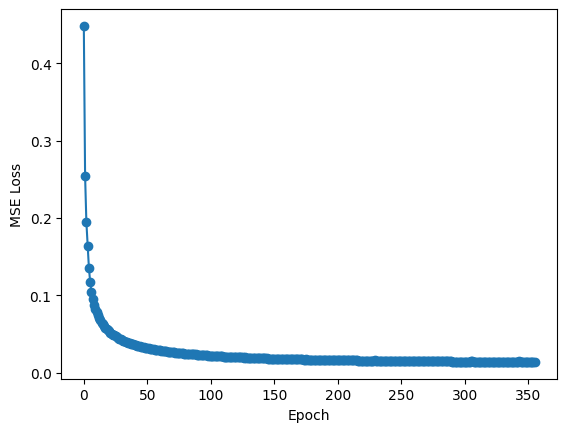

In [8]:
# Plot training loss
plt.figure()
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [12]:
model.eval()
scores, labels = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(DEVICE)
        recon = model(x)
        err = ((x - recon) ** 2)         # shape: [B, 1, 768]
        err = err.view(err.size(0), -1)  # shape: [B, 768]
        err = err.mean(dim=1)            # now shape: [B], 1 scalar per sample
        scores.extend(err.cpu().numpy())
        labels.extend(y)

labels = [int(l) for l in labels]
scores = [float(s) for s in scores]

auc = roc_auc_score(labels, scores)
print('AUC:', auc)



AUC: 0.9423845193508115


In [13]:
print("Unique labels:", set(labels))


Unique labels: {0, 1}


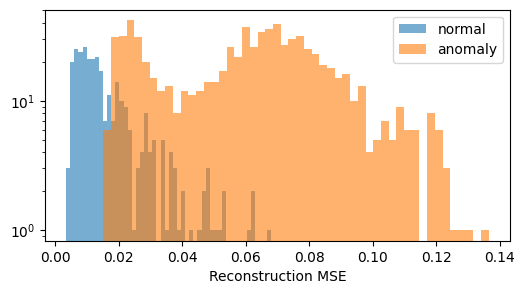

In [14]:
# Error distribution
normal_err = [s for s,l in zip(scores,labels) if l==0]
anom_err   = [s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(normal_err, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom_err,   bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction MSE')
plt.legend()
plt.show()
